## The project process
1. Prepare the data
2. Build the model
3. Train the model
4. Analyze the model's results

<br><br><br>
### Prepare the data
* Extract the data from the data source;
* Transform the data into its desireable format (in PyTorch is tensor format);
* Load the data to a suitable structure for query and analysis
<br> (put the data into an object that can be easily accessed);

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

torch.set_printoptions(linewidth=120) # pytorch output linewidth printed to the console

In [2]:
class OHLC(data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
    
    def __getitem__(self, index):
        r = self.data.iloc[index]
        label = torch.tensor(r.is_up_day, dtype=torch.long)
        sample = self.normalize(torch.tensor([r.open, r.high, r.low, r.close]))
        return sample, lable
    
    def __len__(self):
        return len(self.data)

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [4]:
train_loader = data.DataLoader(train_set, batch_size=10)

In [5]:
len(train_set)

60000

In [6]:
train_set.train_labels

tensor([9, 0, 0,  ..., 3, 0, 5])

In [7]:
train_set.train_labels.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [8]:
# iter() returns a stream of data that we can iterate over

sample = next(iter(train_set))
len(sample)

2

In [9]:
# The returned type is a python sequence type consisting of image and label pairs

type(sample)

tuple

In [10]:
# Sequence unpacking

image, label = sample

In [11]:
image.shape

torch.Size([1, 28, 28])

In [12]:
label.shape

torch.Size([])

label: tensor(9)


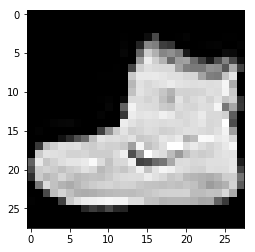

In [13]:
# pass in the image with the color channel squeeze off (remove length=1 axises)
# color map parameter (cmap) set it to 'gray'

plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

In [14]:
batch = next(iter(train_loader))

In [15]:
len(batch)

2

In [16]:
type(batch)

list

In [17]:
images, labels = batch

In [18]:
images.shape

torch.Size([10, 1, 28, 28])

In [19]:
labels.shape

torch.Size([10])

labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


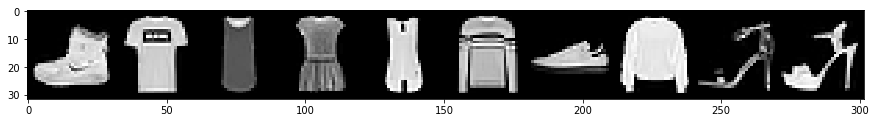

In [20]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels)

In [21]:
train_loader = data.DataLoader(train_set, batch_size=100)

In [22]:
batch = next(iter(train_loader))

In [23]:
images, labels = batch

In [24]:
images.shape

torch.Size([100, 1, 28, 28])

In [25]:
labels.shape

torch.Size([100])

labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5,
        2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1, 6, 3,
        1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8])


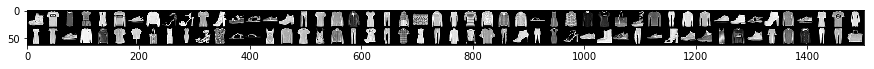

In [26]:
grid = torchvision.utils.make_grid(images, nrow=50)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels)

To build neural network in PyTorch, we extend the `Module` class.

<br> <br> <br> 

### Building a Neural Network in PyTorch
1. Extend the `nn.Module` base class
2. Define layers as class attributes
3. Implement the `forward()` method (using functions in nn.functional)

In [41]:
# nn.Module is keeping track of the weights of the network

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
    
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        # t = F.softmax(t, dim=1)
        
        return t

In [28]:
network = Network()
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [29]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()
        
    
    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

### Two types of parameters
1. Hyperparameters
<br> Hyperparamters are parameters whose values are chosen manually and arbitrarily.<br>
As neural network programmers, we choose hyperparameter values mainly based on trail and error, increasingly by utilizing values that have proven to work well in the past.
<br><br>
    * `kernel_size`: sets the __filter size__ that will be used in the layer. _kernel_ and _filter_ are interchangeable.<br><br>
    * `out_channels`: sets the __number of filters__. Once filter convoles the input channel and produces an output channel. Output channels generate the __feature map.__<br><br>
    * `out_features`: sets the __size of output tensors.__<br><br>

Programmers should determine the value of hyperparameters. We usually test and tune these values to find proper values work the best.<br><br>
2. Data dependent hyperparameters (parameters)
<br> Parameters whose values depend on the data.
    * `in_channels` of the first convolutional layer
    <br> Depend on the number of color channels present inside images that make up the training set. (e.g. Gray-scale images should be one)<br><br>
    * `out_features` of the output layer
    <br> Depend on the number of classes present in the training set.
<br><br>
3. Learnale parameters
<br> Values are learned during the training process.<br>
<br> With learnable parameters, we typically start out with a set of arbituary values, and these values then get updated in an iterative fashion as the network learns.<br>
<br> When we say that a network is learning, we specifically mean that the network is learning the appropriate values for the learnable parameters. <br>
<br> Appropriate values are values that minimize the loss function.
    * `wight` of each layer

In [30]:
network = Network()

In [31]:
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


`stride` tells how far the filter should slide after each convolution operation in the over all convolution. `stride=(1, 1)` means slide down by one unit when moving to the right, and by one unit when moving down.

In [32]:
network.conv1.weight

Parameter containing:
tensor([[[[ 0.1761,  0.1911, -0.1846, -0.0982,  0.1697],
          [-0.1687, -0.0754,  0.0371, -0.0460,  0.1188],
          [-0.1163, -0.1530,  0.0758,  0.1002,  0.0254],
          [ 0.0830, -0.1870, -0.0066,  0.1890, -0.1383],
          [ 0.0485, -0.1832,  0.0772,  0.1228,  0.1662]]],


        [[[-0.1687,  0.1179, -0.1541,  0.0587, -0.1923],
          [-0.1265, -0.0147, -0.1319, -0.0943, -0.0741],
          [ 0.0579, -0.1136,  0.0803, -0.0442,  0.1198],
          [-0.0203, -0.0256,  0.0677, -0.1197, -0.0121],
          [ 0.0208,  0.0348, -0.1476,  0.0196,  0.1264]]],


        [[[ 0.0659,  0.1524, -0.1773,  0.0011, -0.1450],
          [ 0.0739, -0.0359, -0.1075,  0.0589, -0.1180],
          [-0.1604,  0.0183, -0.1758,  0.0808,  0.0732],
          [ 0.1197, -0.1385, -0.1859,  0.0050,  0.1463],
          [-0.0762, -0.1849,  0.0589,  0.0378,  0.1362]]],


        [[[ 0.1079,  0.0190, -0.1273, -0.0134,  0.0638],
          [ 0.0948, -0.0357,  0.0300,  0.1687, -0.1278

In [33]:
# In convolutional layers, the weights are the filter itself 
# (6 filters are packed together into one filter)
# Convolution operations are tensor operations

network.conv1.weight.shape

torch.Size([6, 1, 5, 5])

Weight tensor of a convolution layer has an axises of 4:

    axis 0: the number of filters 
    
    axis 1: the depth of each filter which corresponds to the number of input channels that being convolved
    
    axis 2: the height of each filter
    
    axis 3: the width of each filter

In [34]:
# the fileter now has depth of 6 (number of input channels that filters convolve)

network.conv2.weight.shape

torch.Size([12, 6, 5, 5])

In [35]:
# In fully connected layers, the inputs and outputs are flattened into tensors with axis of one

network.fc1.weight.shape

torch.Size([120, 192])

In [36]:
network.fc2.weight.shape

torch.Size([60, 120])

In [37]:
network.out.weight.shape

torch.Size([10, 60])

In [38]:
# Pytorch Linear Layer class uses the parameter passed in to create an m*n weight matrix

fc = nn.Linear(in_features=4, out_features=3)